# Estudio - Situación de la salud de los datos

#####  https://www.edx.org/course/machine-learning-with-python-from-linear-models-to
- contexto:
    Series de tiempo
- Objetivo:
    Predecir las ventas futuras de determinado artículo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.impute import SimpleImputer
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import re 

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import adfuller

># Funciones auxiliares

In [3]:
def homogenizar_str(text):
    text = str(text).rstrip().lstrip()
    pattern = r'(?![a-zA-Z0-9_ ].).'
    text = re.sub(pattern, '', text )
    return text

def print_valores_en_fecha(data, x_label ="Periodo", y_label="MoImporte", leyenda="idArticulo"):
  data = data.sort_values(by=x_label)
  snplot = sns.catplot(x=x_label, y=y_label,hue=leyenda, kind="point", 
                      data=data[[x_label,y_label,leyenda]],height=5,
                      aspect=2.5,title="{} VS {}".format(y_label,x_label ), palette=sns.color_palette("colorblind"))
  for ax in snplot.axes.flat[:2]:
      ax.tick_params(axis='x', labelrotation=90)

def print_linea_de_tiempo_producto(data, columna,height=2000):
    #df = df_clean#px.data.stocks(indexed=True)-1
    fig = px.line(data, facet_col=columna, facet_col_wrap=3,height=height,facet_row_spacing=0.03 )
    fig.show()

def generar_time_series(data, steps= 3, dropna=False):
  data = data.copy()
  delays = [data.shift(t_delay) for t_delay in range(1,steps+1) ]
  for ti, delayTable in enumerate(delays,1):
    data = data.join(delayTable, rsuffix="_"+str(ti))

  if dropna: data = data.dropna()
  return data

def cv_score_model(data, producto, modelo, scoring='r2', cv=10):
    data = data.filter(regex= producto ).reset_index()
    data['mes'] = data['Periodo'].apply(lambda x: x.month)
    X = data.drop(columns=['Periodo', producto])
    Y = data[producto]
    score = cross_val_score(modelo, X, Y, cv=10, scoring='r2').mean()
    return score

def print_forecasting_results(data, ARIMAfit,fecha_inicio_prediccion, title, ahead=True, dynamic=True): 
    # One Step Ahead Prediction
    predict = ARIMAfit.get_prediction()
    predict_ci = predict.conf_int()
    # Dynamic predictions
    predict_dy = ARIMAfit.get_prediction(dynamic=fecha_inicio_prediccion)
    predict_dy_ci = predict_dy.conf_int()

    # Graph
    fig, ax = plt.subplots(figsize=(15,4))
    ax.set(title=title, xlabel='Date', ylabel='Valores escalados')

    # Plot data points 
    data.plot(ax=ax, style='o', label='Valores reales')

    # Plot predictions

    # Plot 'One-step-ahead forecast'
    if ahead:
        tabla_pred = predict.predicted_mean.loc[fecha_inicio_prediccion:]
        tabla_pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
        ci = predict_ci.loc[fecha_inicio_prediccion:]
        ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1 )
        
        result = data.loc[fecha_inicio_prediccion:].join(tabla_pred)
        print(result)

    # Plot 'Dynamic forecast'
    if dynamic:
        predict_dy.predicted_mean.loc[fecha_inicio_prediccion:].plot(ax=ax, style='g', label='Dynamic forecast')
        ci = predict_dy_ci.loc[fecha_inicio_prediccion:]
        ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

    legend = ax.legend(loc='upper left')

def test_stationarity(timeseries,producto, window=6, ):
    """('Results of Dickey-Fuller Test:')
    https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller
    """
    dftest = adfuller(timeseries.iloc[:,0],maxlag=10, autolag='t-stat')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    dfoutput['idArticulo'] = producto
    dfoutput['H0'] = 'fail' if dftest[1] < 0.05 else 'pass'
    dfoutput['Unit root'] = 'No' if dftest[1] < 0.05 else 'Yes'
    return dfoutput
    #print (dfoutput)
    return dfoutput

## Cargas datos del Google Drive


In [4]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd ../gdrive/MyDrive/Projects/Time_series

In [5]:
!ls ../data/

Data_Repuestos_2018_2021.csv  Data_Repuestos_2018_2021.xlsx  producto.csv


># **Objeto de estudio** 

### Base de datos: 
- Data repuestos 2018 - 2021


In [6]:
df_study = pd.read_csv("../data/Data_Repuestos_2018_2021.csv", 
                       header=1, 
                       usecols=[' noPeriodo',' idArticulo','MoImporte',' moPrecio', 'CnSalida 2018', ' caDescProduct'],
                       )

df_study.rename(columns={
    ' noPeriodo':'Periodo',
    ' idArticulo':'idArticulo',
    ' moPrecio':'moPrecio',
    'CnSalida 2018':'cantSalida',
    ' caDescProduct':'DescProducto'
    }, inplace=True)
    
df_study['idArticulo'] = df_study['idArticulo'].astype(str)
df_study.Periodo = df_study.Periodo.apply(lambda x: datetime.strptime(str(x), "%Y%m00").date())

df_study.head()

Periodo idArticulo  cantSalida  moPrecio  MoImporte  \
0  2018-01-01      25319         1.0     15.00       15.0   
1  2018-01-01       4923         1.0     23.00       23.0   
2  2018-01-01      25853         1.0     13.00       13.0   
3  2018-01-01      13497         1.0     90.00       90.0   
4  2018-01-01      23900         4.0      6.25       25.0   

                                       DescProducto  
0                         FOCO H11-12 100-90W CURVO  
1                        FILTRO AIRE HYUNDAI TUCSON  
2   FILTRO GASOLINA NISSAN METAL GA15-16 INJECTADO   
3                    JGO CABLES BUJIA KIA RIO LARGO  
4                                         BUJIA NGK

In [7]:
df_study.nunique()

Periodo            41
idArticulo      14088
cantSalida        238
moPrecio         2255
MoImporte        3133
DescProducto    19553
dtype: int64

In [8]:
df_study.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99954 entries, 0 to 99953
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Periodo       99954 non-null  object 
 1   idArticulo    99954 non-null  object 
 2   cantSalida    99954 non-null  float64
 3   moPrecio      99954 non-null  float64
 4   MoImporte     99954 non-null  float64
 5   DescProducto  99951 non-null  object 
dtypes: float64(3), object(3)
memory usage: 4.6+ MB


Se extraen solo las columnas de interes

## Homogenizando datos de descripción

In [9]:
df_study["DescProducto"] = df_study["DescProducto"].apply(homogenizar_str)
df_study.head()

Periodo idArticulo  cantSalida  moPrecio  MoImporte  \
0  2018-01-01      25319         1.0     15.00       15.0   
1  2018-01-01       4923         1.0     23.00       23.0   
2  2018-01-01      25853         1.0     13.00       13.0   
3  2018-01-01      13497         1.0     90.00       90.0   
4  2018-01-01      23900         4.0      6.25       25.0   

                                   DescProducto  
0                        FOCO H1112 10090W CURV  
1                     FILTRO AIRE HYUNDAI TUCSO  
2  FILTRO GASOLINA NISSAN METAL GA1516 INJECTAD  
3                 JGO CABLES BUJIA KIA RIO LARG  
4                                      BUJIA NG

## Seleccionamos solo las ventas significativas

In [10]:
df_study = df_study.query('MoImporte > 0 and moPrecio > 0 and cantSalida > 0')
df_study.describe()

cantSalida      moPrecio     MoImporte
count  91605.000000  91605.000000  91605.000000
mean       4.841033     39.590109     49.637836
std       69.095591     49.602833     74.309288
min        0.300000      0.010000      0.010000
25%        1.000000     10.000000     15.000000
50%        1.000000     20.000000     25.000000
75%        1.000000     50.000000     60.000000
max    10000.000000   1890.000000  10140.000000

## Agrupando las Ventas según Periodo y idArtículo

Usamos el método de agragación suma para cada artículo de ese modo obtendremos cuanto fue la venta total de aquel procuto por cada periodo.

In [11]:
df_group = df_study.groupby(['Periodo', 'idArticulo']).agg({'cantSalida':'sum', 
                                                            'moPrecio':'sum', 
                                                            'MoImporte':'sum',
                                                            'DescProducto':'last'})
df_group.reset_index(inplace=True)                                           
df_group.head()

Periodo idArticulo  cantSalida  moPrecio  MoImporte  \
0  2018-01-01      10018         1.0     50.00      50.00   
1  2018-01-01      10028         3.0    101.34     304.02   
2  2018-01-01      10065         1.0     70.00      70.00   
3  2018-01-01      10069        54.0      0.28       5.28   
4  2018-01-01      10076         9.0      7.63      68.67   

                                      DescProducto  
0  JGO CABLES BUJIA TOYOTA VARIOS 18R 77  78 CORON  
1            JGO CABLES BUJIA TOYOTA 4A JAPON 7002  
2                POLEA TEMPLADOR NUBIRA 20 GT90540  
3                   MANGUERA ACEITE JEBE LONA X CM  
4             FAJA DISTRIBUCION DR HYUNDAI A345M07

In [12]:
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57921 entries, 0 to 57920
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Periodo       57921 non-null  object 
 1   idArticulo    57921 non-null  object 
 2   cantSalida    57921 non-null  float64
 3   moPrecio      57921 non-null  float64
 4   MoImporte     57921 non-null  float64
 5   DescProducto  57921 non-null  object 
dtypes: float64(3), object(3)
memory usage: 2.7+ MB


# Productos y su presencia en los Periodos

- Cada año tiene 12 meses.
- Tomaremos aquellos productos con al menos 36 meses de presencia en la línea de tiempo, es decir en los 3 años
- detectamos que tenemos 48 artículos únicos que cumplen todos los requisitos


In [16]:
temp = df_group.loc[:,['idArticulo']]
temp['count'] = 1
temp = temp.groupby('idArticulo').count()
temp = temp.sort_values('count', ascending=False)
temp = temp.reset_index()
temp = temp.query('count > 36')
temp.idArticulo.nunique()

48

### Estos son los productos

In [17]:
lista_articulos = temp.idArticulo.unique().tolist()
df_clean = df_group.loc[df_group['idArticulo'].isin(lista_articulos)]
df_clean = df_clean.reset_index(drop=True)
df_clean.head()

Periodo idArticulo  cantSalida  moPrecio  MoImporte  \
0  2018-01-01      10702         1.0     10.00      10.00   
1  2018-01-01      10927        71.0      8.17      80.18   
2  2018-01-01      10960        32.0    540.05    1165.68   
3  2018-01-01      10964        11.0    462.15     645.03   
4  2018-01-01      11395       168.0    117.19     728.88   

                               DescProducto  
0  SILICONA GRIS UTK SUPER GREY 85GR GRANDE  
1                  ABRAZADERA PLASTICA LARG  
2           REFRIGERANTE PRESTONE  33  GALO  
3             REFRIGERANTE PRESTONE 5050 US  
4             BUJIA NGK 58 1E RL 7938 NISSA

In [18]:
df_clean.to_csv('../data/producto.csv', index=False)

># **EDA**
- Corrección de valores atipicos
- Imputar datos perdidos
- Pivotear tabla
- Escalar y centralizar valores

### Corregir idArticulo : 9776

Se detecta un valor atipico durante el gráfico de su histograma

In [15]:
df_clean.drop(df_clean.loc[(df_clean.idArticulo == '9776') & (df_clean.MoImporte > 5000)].index, inplace=True)

### Creando las series de tiempo para cada producto
- Pivotear tabla generando una columna por cada producto
- Rellenar los valores perdidos con la media de cada producto



In [16]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_time_pre = df_clean.pivot_table(index='Periodo', columns='idArticulo', values='MoImporte', aggfunc='sum',)
df_time = imp_mean.fit_transform(df_time_pre)
df_time = pd.DataFrame(df_time, columns=df_time_pre.columns, index=df_time_pre.index)
df_time.head()

idArticulo  10702   10927    10960   10964    11395   11397   11509  11523  \
Periodo                                                                      
2018-01-01   10.0   80.18  1165.68  645.03   728.88   56.00   55.00   5.50   
2018-02-01  124.0   23.28   576.40  335.66   757.74  302.45   50.00   9.00   
2018-03-01   70.0   21.00   926.45  770.09  1504.50  926.80  254.74   6.00   
2018-04-01   40.0  135.35   862.70  860.54   602.92   50.00  159.38  15.00   
2018-05-01   32.0   38.01   425.00   50.00   536.75  424.45  339.05  42.42   

idArticulo   11807   1208  ...     5389     551    5579     594   6833  \
Periodo                    ...                                           
2018-01-01  349.41   8.94  ...   512.88   39.50  155.42  315.00  24.00   
2018-02-01   60.00  22.66  ...   295.00  100.00   75.00  376.56  60.14   
2018-03-01   50.00  30.15  ...   460.00  208.90   87.50  349.75  25.00   
2018-04-01   28.00  53.41  ...   295.00  174.00   87.00  557.36  82.04   
2018-05-01   30.00   7.75  ...  1004.16  528.18  451.46  100.00  75.00   

idArticulo       7798   7799    7801    9776    9950  
Periodo                                               
2018-01-01  31.040541  46.83   20.00   87.71  542.16  
2018-02-01  25.000000  12.00   41.50   87.43  907.36  
2018-03-01  68.000000  88.50  148.71  171.87  170.00  
2018-04-01  39.000000  53.00   11.00   84.35  606.13  
2018-05-01  12.000000  12.00   84.00  113.78  625.76  

[5 rows x 48 columns]

## Escalando los valores - Homogenizar amplitud

In [17]:
scaler = StandardScaler().fit(df_time)
df_time_scaled = scaler.transform(df_time)
df_time_scaled = pd.DataFrame(df_time_scaled, columns=df_time.columns, index=df_time.index)
df_time_scaled.head()

idArticulo     10702     10927     10960     10964     11395     11397  \
Periodo                                                                  
2018-01-01 -1.104662  1.519405  1.095282  0.771126  0.683853 -0.783261   
2018-02-01  0.713187 -0.315460 -0.589390 -0.632403  0.771658  0.409047   
2018-03-01 -0.147900 -0.388984  0.411356  1.338489  3.043618  3.429610   
2018-04-01 -0.626281  3.298483  0.229103  1.748836  0.300629 -0.812289   
2018-05-01 -0.753849  0.159541 -1.022222 -1.928365  0.099312  0.999275   

idArticulo     11509     11523     11807      1208  ...      5389       551  \
Periodo                                             ...                       
2018-01-01 -0.794688 -0.593086  3.355878 -0.708692  ...  1.005938 -0.642341   
2018-02-01 -0.836973 -0.319194 -0.186958 -0.459632  ... -0.142614 -0.078905   
2018-03-01  0.894506 -0.553958 -0.309374 -0.323665  ...  0.727182  0.935280   
2018-04-01  0.088050  0.150334 -0.578688  0.098576  ... -0.142614  0.610256   
2018-05-01  1.607512  2.296077 -0.554205 -0.730294  ...  3.595715  3.908731   

idArticulo      5579       594      6833          7798      7799      7801  \
Periodo                                                                      
2018-01-01  0.675796  0.217505 -0.577134  1.885605e-16  0.077319 -0.891256   
2018-02-01 -0.192233  0.688033  0.517210 -3.206020e-01 -1.172500 -0.152189   
2018-03-01 -0.057312  0.483113 -0.546853  1.961625e+00  1.572582  3.533176   
2018-04-01 -0.062709  2.069963  1.180357  4.224488e-01  0.298720 -1.200633   
2018-05-01  3.871160 -1.425830  0.967181 -1.010578e+00 -1.172500  1.308757   

idArticulo      9776      9950  
Periodo                         
2018-01-01 -0.234222  1.155654  
2018-02-01 -0.240134  2.778873  
2018-03-01  1.542867 -0.498501  
2018-04-01 -0.305170  1.439984  
2018-05-01  0.316262  1.527234  

[5 rows x 48 columns]

## Graficando las series de tiempo de cada Producto

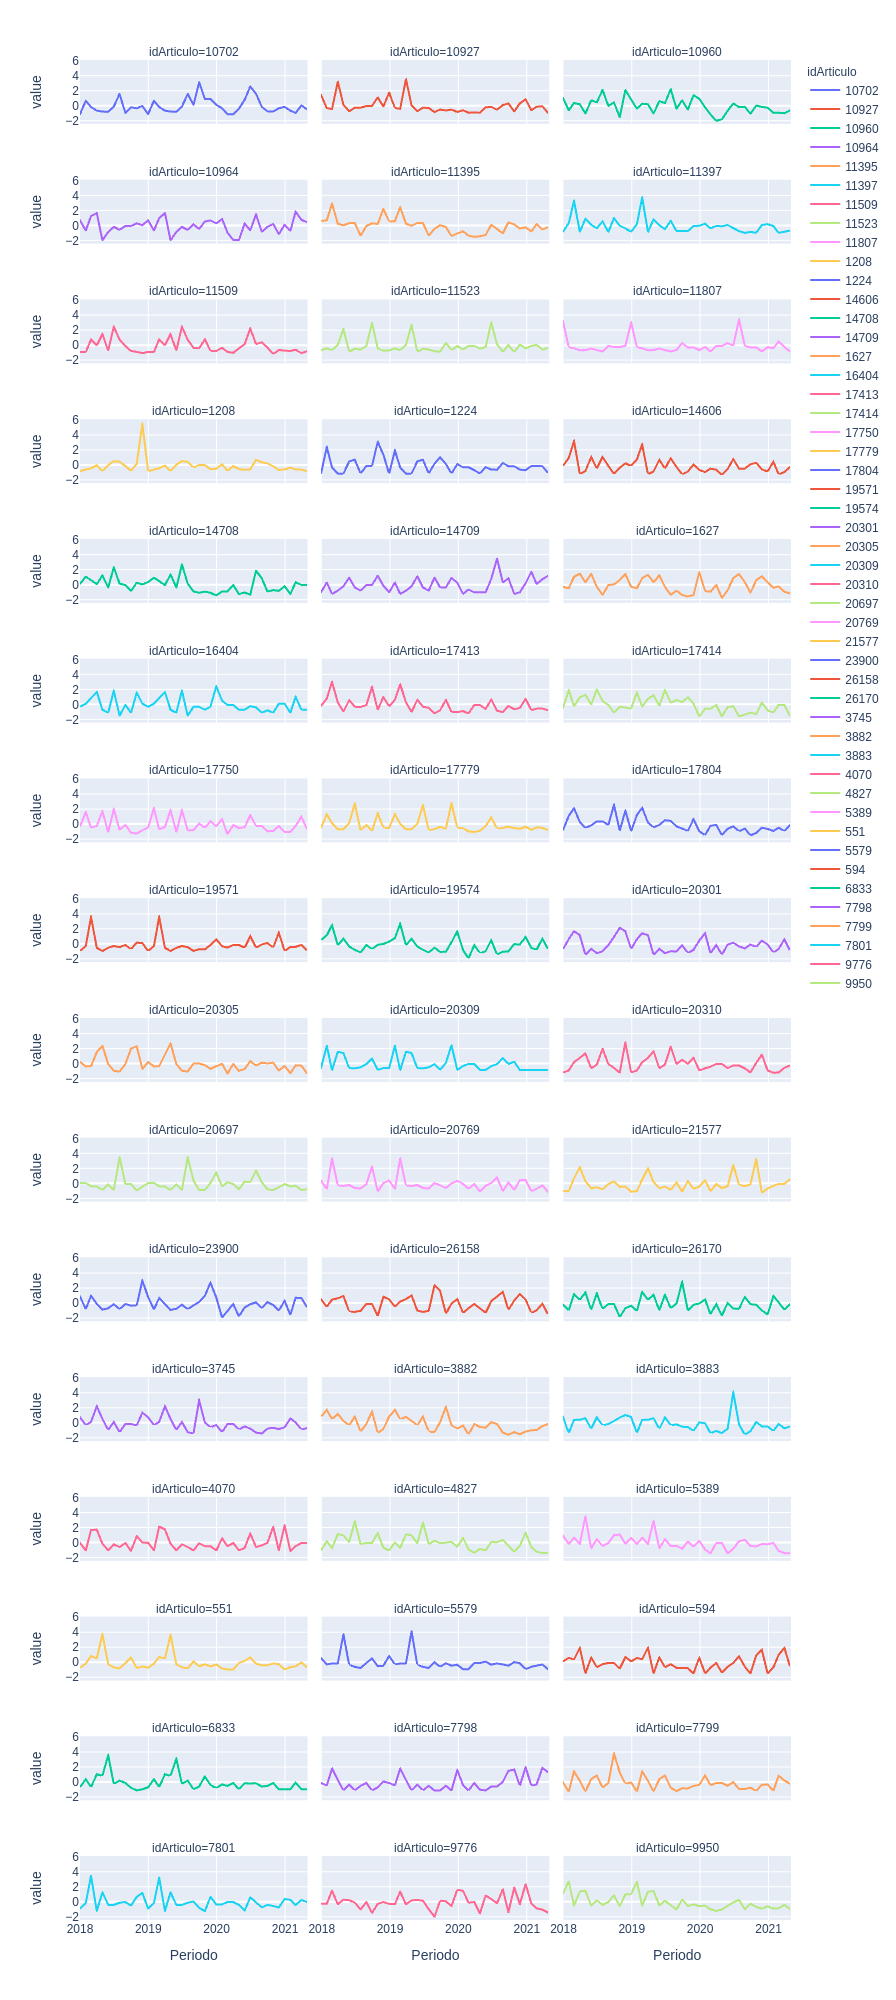

In [18]:
print_linea_de_tiempo_producto(df_time_scaled , 'idArticulo')

## Graficando distribución de cada producto


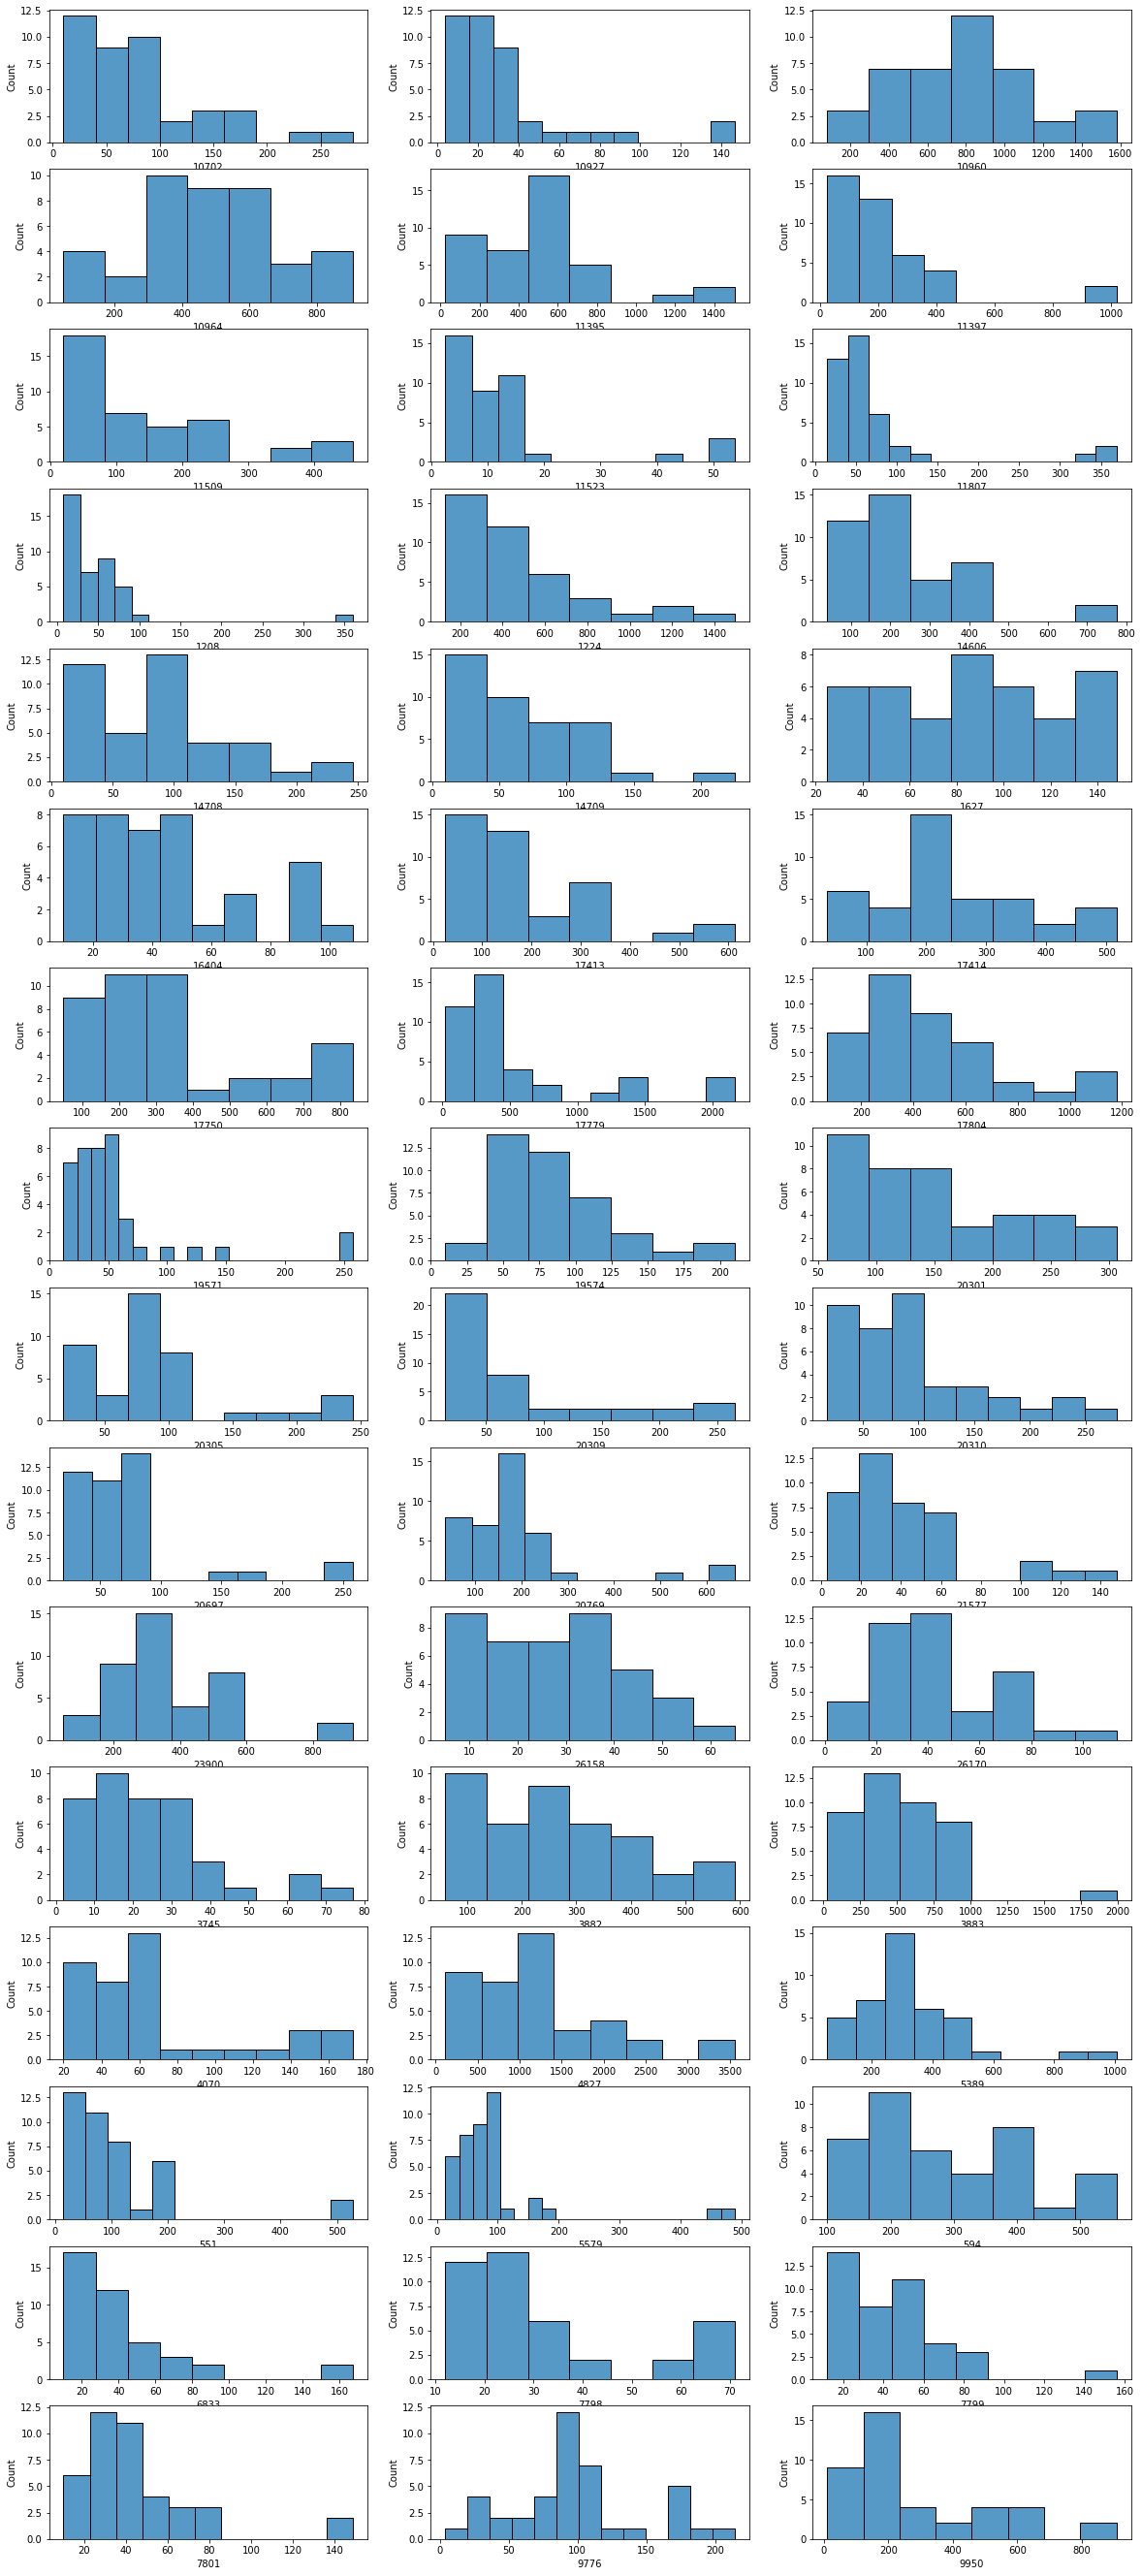

In [19]:
columns_num = list(df_time.columns)
columns_num = sorted(columns_num)
fig, axes = plt.subplots(nrows=round(len(columns_num)/3), ncols=3, figsize=(20,int(3*round(len(columns_num)/3))))
for ax, column in zip(axes.flatten(),columns_num):
    sns.histplot(df_time[column], ax=ax )

># Preprocesamiento de datos
* Realizamos el delay para nuestros modelo predictor

In [20]:
"""
Y(t)* = y(t) - y(t-1)
Y(t)** = y(t)* - y(t-1)*
Y(t)*** = y(t)** - y(t-1)** 
"""

df_diff = df_time_scaled.diff().diff().diff()
df_train = generar_time_series(df_diff, steps=3, dropna=True)
df_train.head(3)

idArticulo     10702     10927     10960     10964     11395     11397  \
Periodo                                                                  
2018-07-01  0.653788 -0.913240 -5.160764 -5.197007 -0.757837  2.997583   
2018-08-01  0.239191 -1.838412  4.110703 -0.712267 -1.449563  1.059265   
2018-09-01 -5.278140  0.711456 -5.887252  2.069004  4.731357 -3.786650   

idArticulo      11509     11523     11807      1208  ...     5389_3  \
Periodo                                              ...              
2018-07-01   9.226291  8.745742 -0.636562 -1.988308  ...  -3.757939   
2018-08-01 -10.475215 -4.062983  0.477422 -0.304427  ...   6.347715   
2018-09-01   5.907767  1.140869  0.884728  0.115449  ... -12.691003   

idArticulo      551_3     5579_3      594_3    6833_3    7798_3    7799_3  \
Periodo                                                                     
2018-07-01  -1.789957  -1.143268   2.467218  4.949681 -6.424233 -8.013845   
2018-08-01   4.962706   4.079584  -6.874411 -4.731660  3.927554  3.821585   
2018-09-01 -10.993427 -12.012083  10.764451  4.942414  2.123002  3.373042   

idArticulo     7801_3    9776_3     9950_3  
Periodo                                     
2018-07-01 -11.365474 -5.419951  10.116453  
2018-08-01  15.662374  6.100507  -7.067094  
2018-09-01 -11.436974 -3.164595  -0.261751  

[3 rows x 192 columns]

## Example of training data

In [21]:
df_train.filter(regex='10702').head()

idArticulo     10702   10702_1   10702_2   10702_3
Periodo                                           
2018-07-01  0.653788 -0.255137 -0.031892  3.061640
2018-08-01  0.239191  0.653788 -0.255137 -0.031892
2018-09-01 -5.278140  0.239191  0.653788 -0.255137
2018-10-01  7.638154 -5.278140  0.239191  0.653788
2018-11-01 -4.241647  7.638154 -5.278140  0.239191

># Training Test - Linea Model
- Se testearan los datos usando cross validation con el modelo LinearRegression

In [22]:
# regr = svm.SVR()
regr = linear_model.LinearRegression()

score_table = pd.DataFrame()
for producto in df_diff.columns:
    score = cv_score_model(df_train, producto, regr)
    score_table = score_table.append({'producto': producto, 'score': score}, ignore_index=True)

In [23]:
score_table.sort_values(by='score', ascending=False, inplace=True)
score_table.head(20)

producto     score
43     7798  0.724099
16    17413  0.684631
3     10964  0.673092
7     11523  0.668984
22    19574  0.661223
32    26170  0.657189
4     11395  0.640197
30    23900  0.621991
31    26158  0.612540
23    20301  0.608851
36     4070  0.564699
46     9776  0.534826
18    17750  0.533637
34     3882  0.522363
44     7799  0.496993
15    16404  0.481393
24    20305  0.466092
10     1224  0.462286
13    14709  0.461467
40     5579  0.460477

># Dickey-Fuller Test

EL H0 tiene que fallar para poder enunciar que hay evidencias que la serie es estacionaria.

In [24]:
adfuller_table = pd.DataFrame()
for producto in df_diff.columns:
    result = test_stationarity(df_time_scaled[[producto]], producto)
    adfuller_table = adfuller_table.append(result, ignore_index=True)

In [25]:
print ('Results of Dickey-Fuller Test:')
adfuller_table.sort_values(by='p-value', ascending=True, inplace=True)
adfuller_table[["idArticulo", "p-value", 'H0','Unit root']].head(20)

Results of Dickey-Fuller Test:


idArticulo       p-value    H0 Unit root
28      20769  1.801981e-11  fail        No
32      26170  3.298679e-11  fail        No
15      16404  2.605805e-10  fail        No
21      19571  1.441881e-09  fail        No
8       11807  2.158028e-09  fail        No
46       9776  3.835567e-09  fail        No
5       11397  4.012317e-09  fail        No
25      20309  5.509380e-09  fail        No
7       11523  1.028919e-08  fail        No
38       5389  3.860554e-08  fail        No
40       5579  4.540964e-08  fail        No
35       3883  5.133399e-08  fail        No
29      21577  8.045724e-08  fail        No
9        1208  1.062412e-07  fail        No
3       10964  1.131076e-07  fail        No
31      26158  7.904814e-07  fail        No
44       7799  1.036695e-06  fail        No
2       10960  3.502175e-06  fail        No
37       4827  3.675986e-06  fail        No
33       3745  4.028727e-06  fail        No

># ARIMA models

In [76]:
def print_forecasting_results(data, ARIMAfit,fecha_inicio_prediccion, title, producto, ahead=True, dynamic=True): 
    def calcular_r2 (dato_r, pred, producto, fecha_inicio_prediccion ): 
        init_date = datetime.datetime.strptime(fecha_inicio_prediccion, '%Y-%m-%d').date()
        dato_r2 = dato_r.reset_index().set_index('Periodo').loc[init_date:,:]
        dato_r2 = pd.DataFrame(pred).join(dato_r2)
        print(dato_r2)
        r2val = r2_score( dato_r2[producto],dato_r2['predicted_mean'] )
        return r2val
    # One Step Ahead Prediction
    predict = ARIMAfit.get_prediction()
    predict_ci = predict.conf_int()
    # Dynamic predictions
    predict_dy = ARIMAfit.get_prediction(dynamic=fecha_inicio_prediccion)
    predict_dy_ci = predict_dy.conf_int()

    # Graph
    fig, ax = plt.subplots(figsize=(15,4))
    ax.set(title=title, xlabel='Date', ylabel='Valores escalados')

    # Plot data points 
    data.plot(ax=ax, style='o', label='Valores reales')

    # Plot predictions

    # Plot 'One-step-ahead forecast'
    if ahead:
        tabla_pred = predict.predicted_mean.loc[fecha_inicio_prediccion:]
        tabla_pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
        ci = predict_ci.loc[fecha_inicio_prediccion:]
        ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1 )
        
    r2val =  calcular_r2(data, tabla_pred, producto, fecha_inicio_prediccion)
    print(f" {producto} - El valor del r2 es : {r2val} ")
        

    # Plot 'Dynamic forecast'
    if dynamic:
        predict_dy.predicted_mean.loc[fecha_inicio_prediccion:].plot(ax=ax, style='g', label='Dynamic forecast')
        ci = predict_dy_ci.loc[fecha_inicio_prediccion:]
        ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

    legend = ax.legend(loc='upper left')

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 10702 - El valor del r2 es : -0.29323487570687967 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 10927 - El valor del r2 es : -7.5860281952633635 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 10960 - El valor del r2 es : -0.2810560405932374 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 10964 - El valor del r2 es : -1.5531854595689745 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 11395 - El valor del r2 es : -2.4667934070623376 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 11397 - El valor del r2 es : -8.891527145349478 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 11509 - El valor del r2 es : -0.7039622660017426 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 11523 - El valor del r2 es : -4.3630267319027505 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 11807 - El valor del r2 es : -2.190453861268465 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 1208 - El valor del r2 es : -20.453870846834796 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 1224 - El valor del r2 es : -6.96907223483665 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 14606 - El valor del r2 es : -5.21290629858384 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 14708 - El valor del r2 es : -2.207289877038429 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 14709 - El valor del r2 es : -1.6162771092175197 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 1627 - El valor del r2 es : -1.8459596198992547 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 16404 - El valor del r2 es : -2.966316173571447 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 17413 - El valor del r2 es : -7.499496737653864 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 17414 - El valor del r2 es : -1.5616384889382395 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 17750 - El valor del r2 es : -2.0625422468294285 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 17779 - El valor del r2 es : -1.9151288945289182 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/home/davelinux/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 17804 - El valor del r2 es : -4.43949650907052 
 19571 - El valor del r2 es : -6.161808294585104 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 19574 - El valor del r2 es : -2.3793712911694795 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 20301 - El valor del r2 es : -3.6502704976361047 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 20305 - El valor del r2 es : -6.518966022205626 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 20309 - El valor del r2 es : -3.293364334414255 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 20310 - El valor del r2 es : -2.2778130765645637 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 20697 - El valor del r2 es : -0.37561883184512546 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 20769 - El valor del r2 es : -5.276738229058464 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 21577 - El valor del r2 es : -1.308379418574014 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 23900 - El valor del r2 es : -0.2557366574813029 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 26158 - El valor del r2 es : -0.6597162002277079 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 26170 - El valor del r2 es : -1.6610473884138086 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 3745 - El valor del r2 es : -2.072129425643637 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 3882 - El valor del r2 es : -2.616075213751881 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 3883 - El valor del r2 es : -0.7984832766989212 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 4070 - El valor del r2 es : -1.7111188135512667 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 4827 - El valor del r2 es : -1.5552899777194447 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 5389 - El valor del r2 es : -2.4182673932434575 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 551 - El valor del r2 es : -9.48412674517059 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 5579 - El valor del r2 es : -14.669533353016613 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 594 - El valor del r2 es : -1.0167548216068232 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 6833 - El valor del r2 es : -5.576960288079848 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 7798 - El valor del r2 es : -0.5759227674757783 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



 7799 - El valor del r2 es : -7.585291479626452 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 7801 - El valor del r2 es : -6.604086300739439 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 9776 - El valor del r2 es : -0.6497015954056622 


/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/davelinux/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



 9950 - El valor del r2 es : -4.667539510924679 


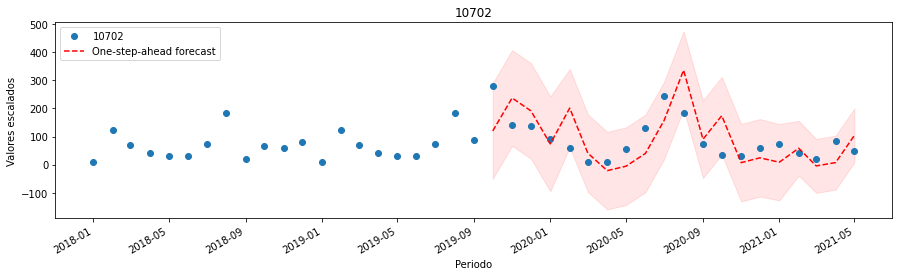

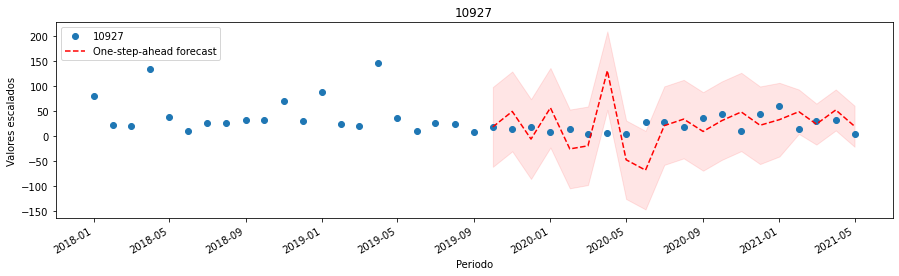

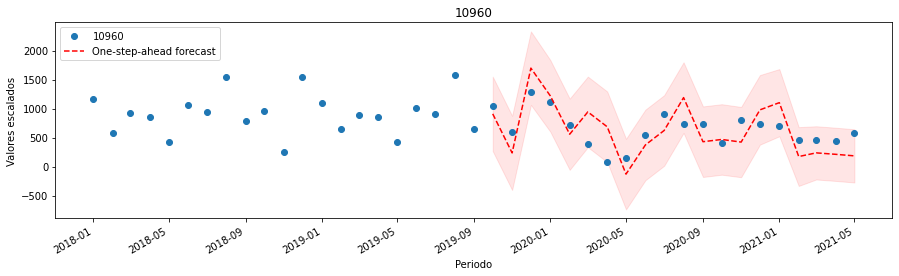

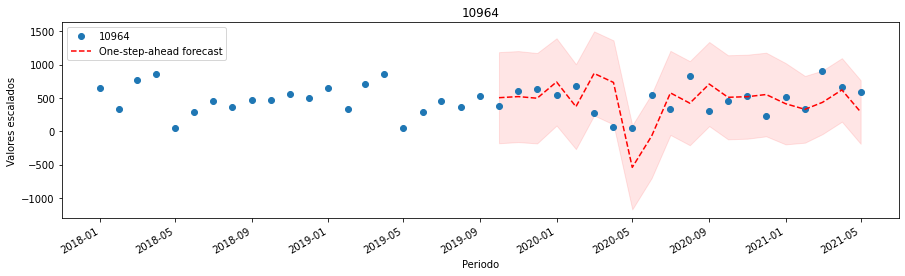

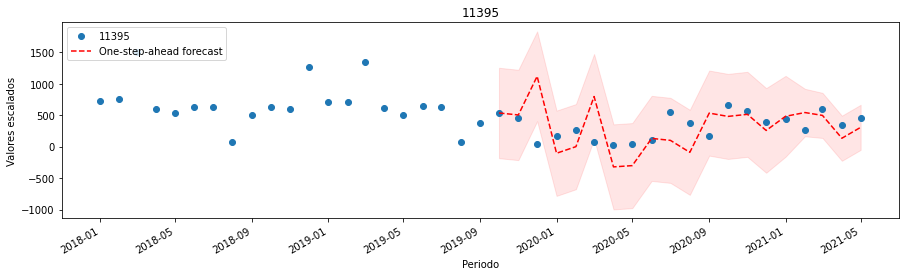

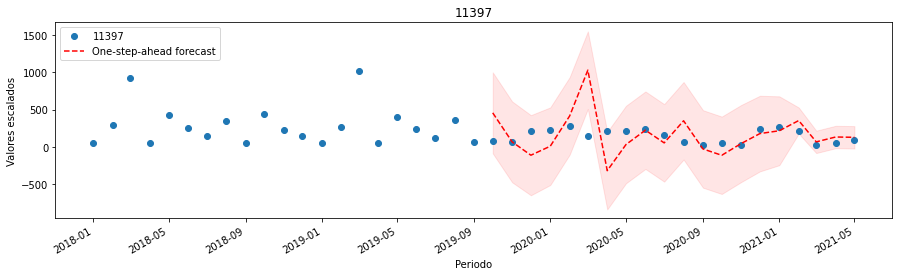

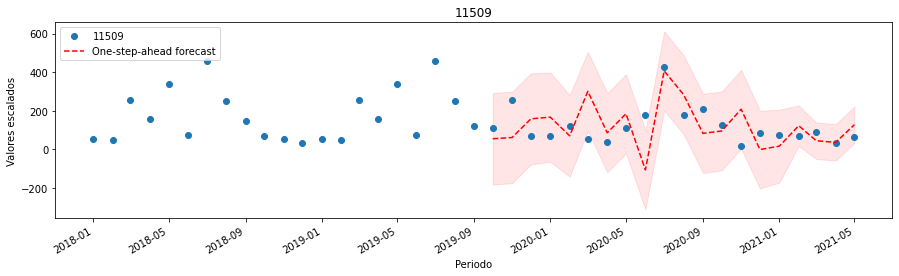

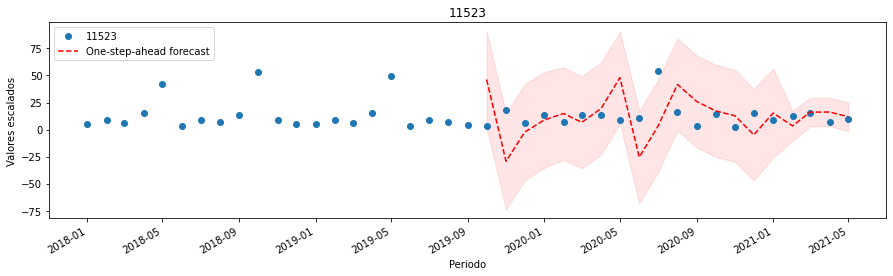

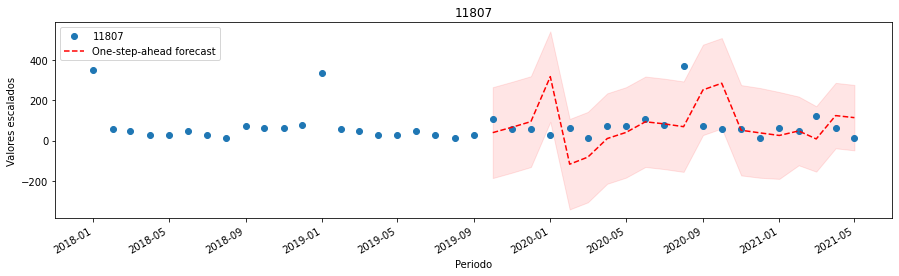

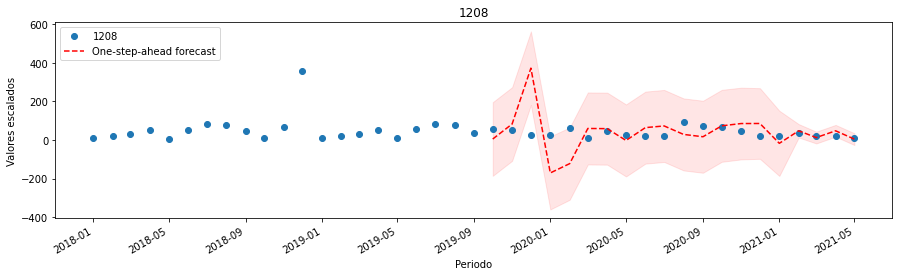

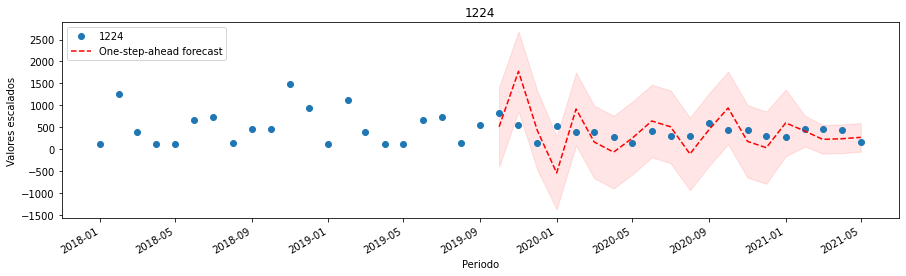

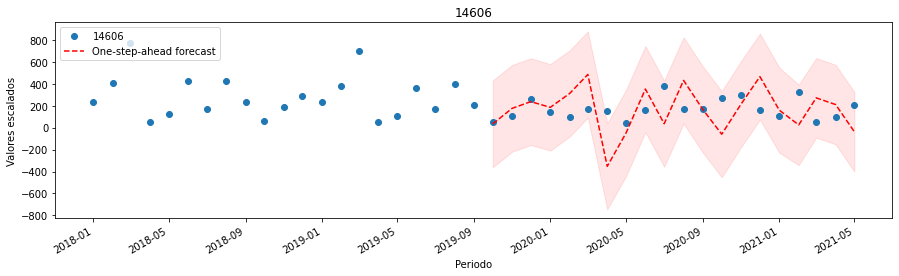

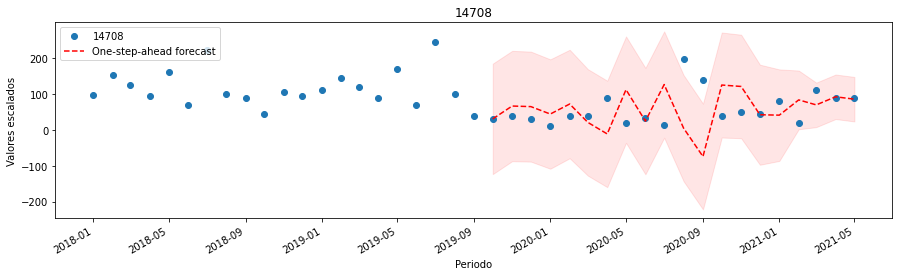

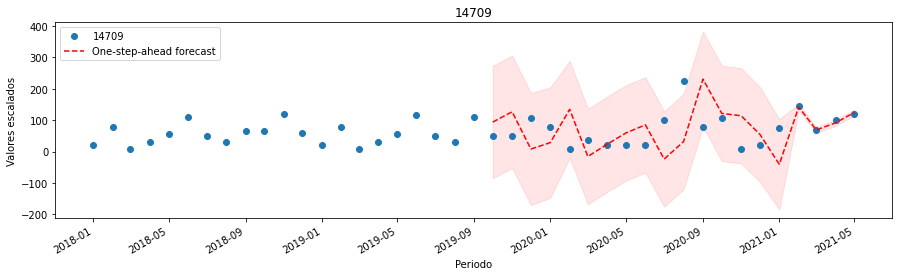

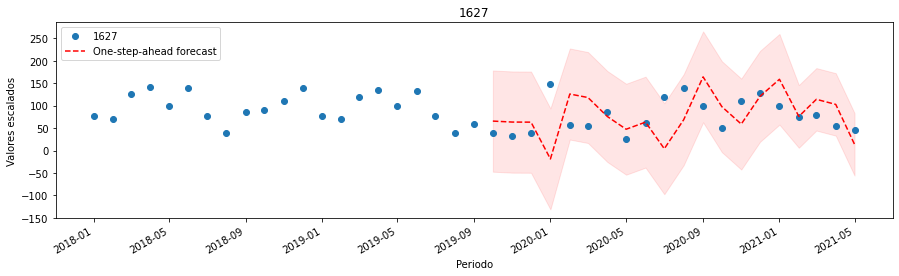

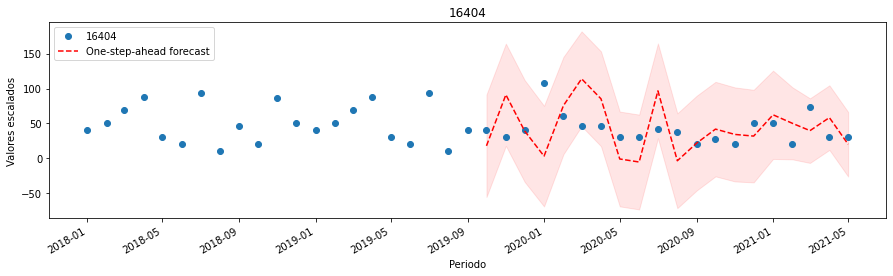

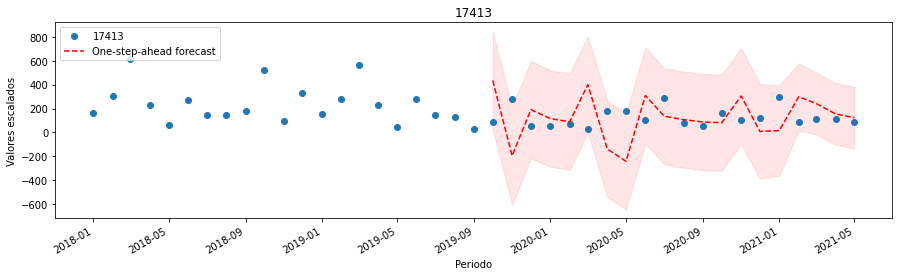

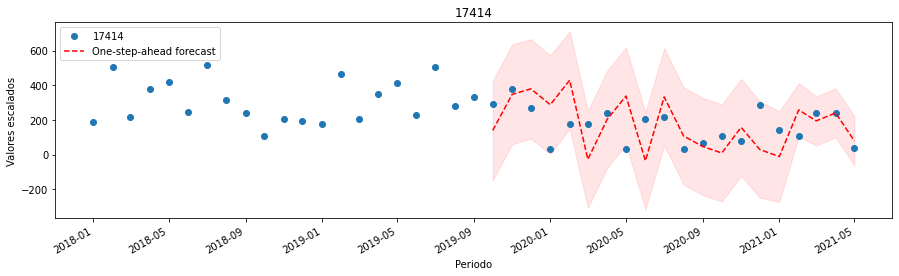

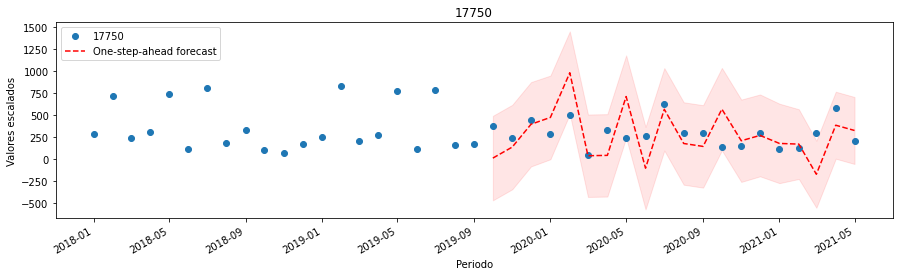

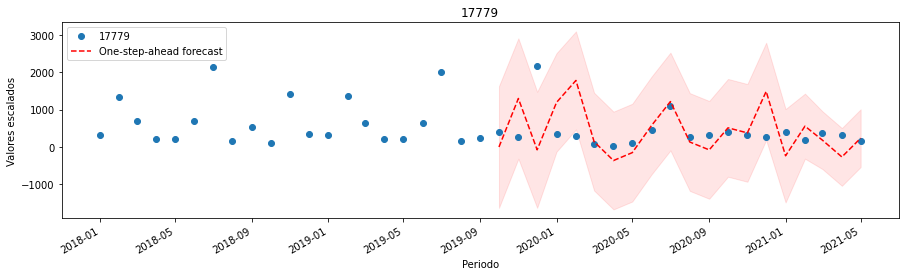

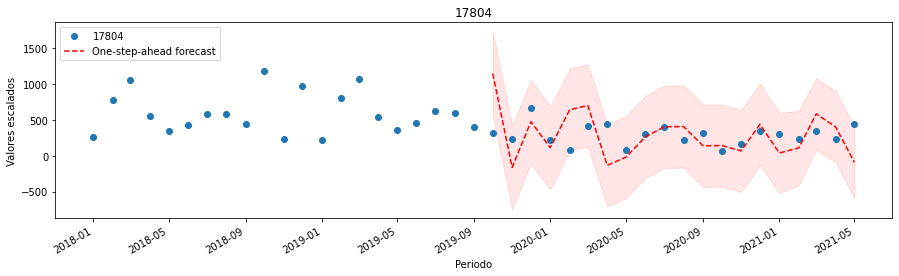

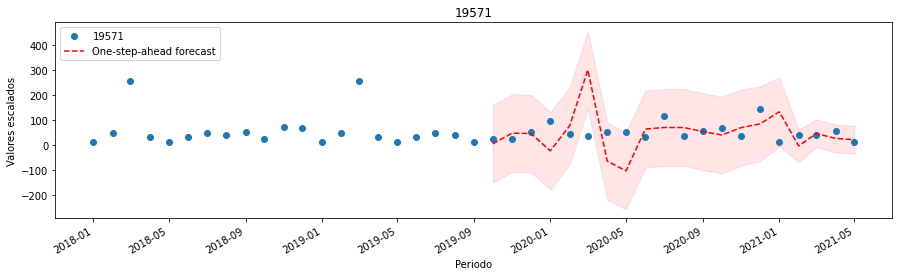

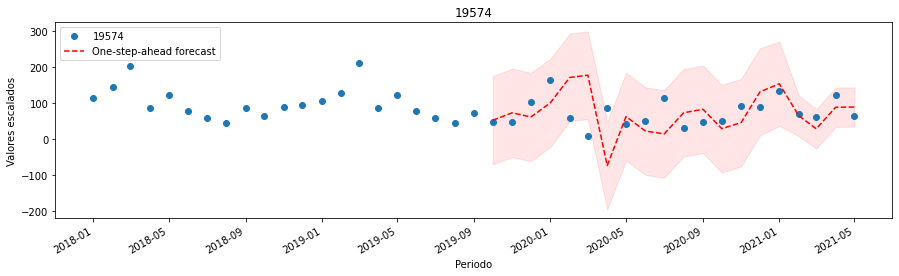

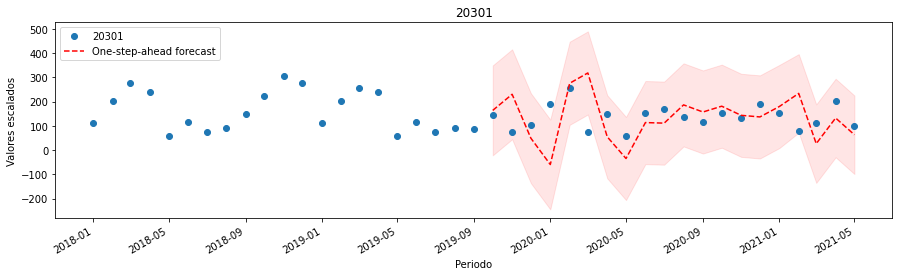

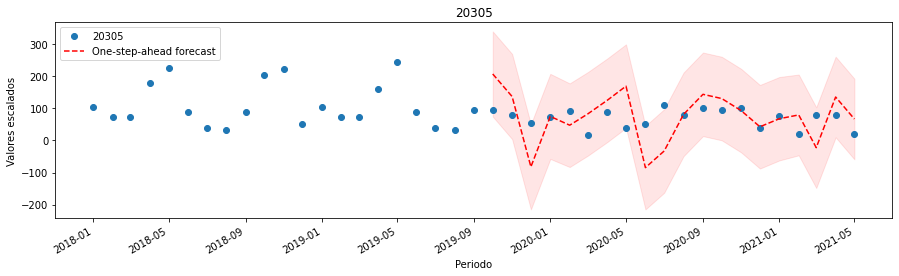

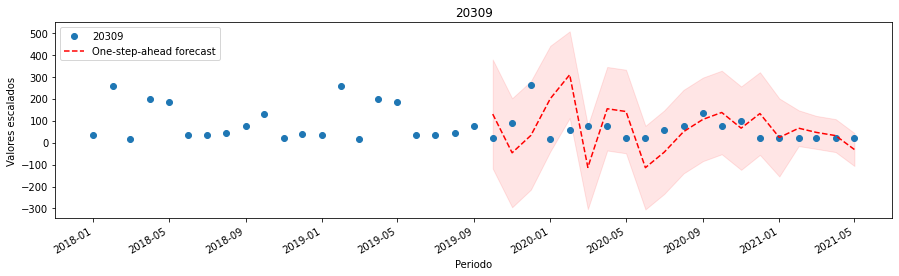

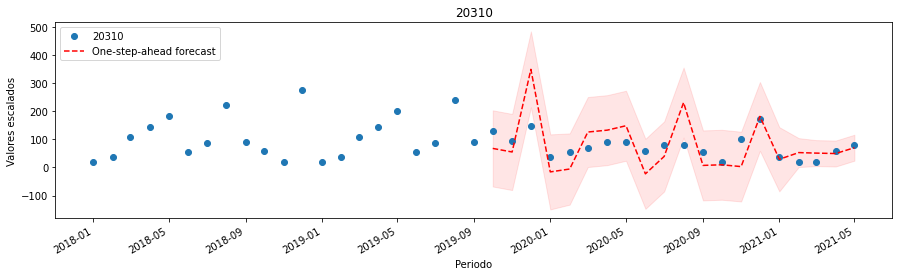

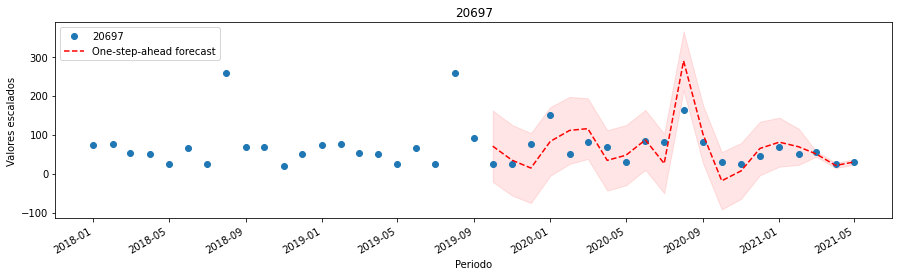

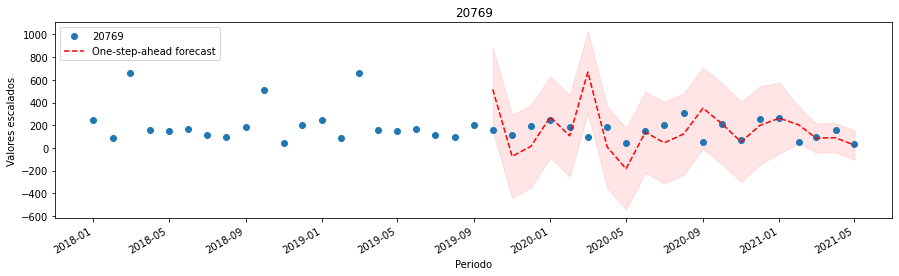

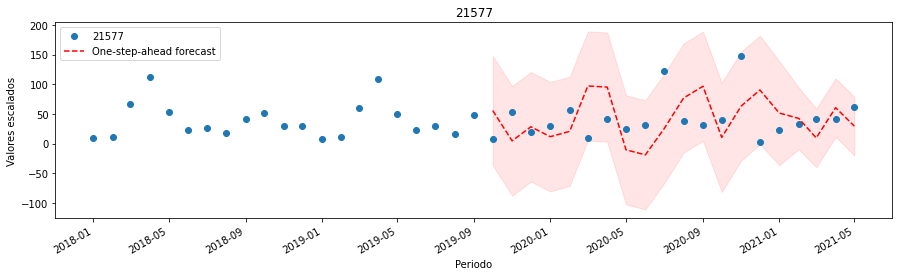

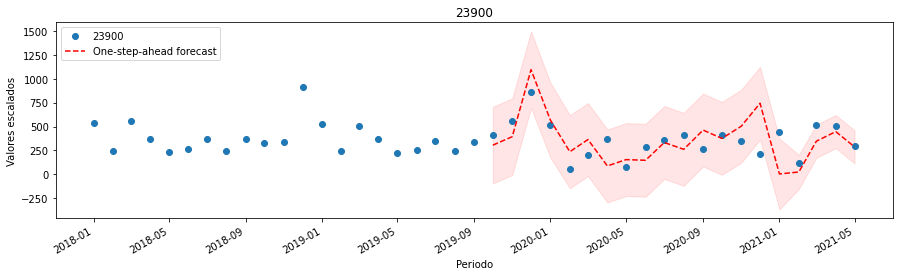

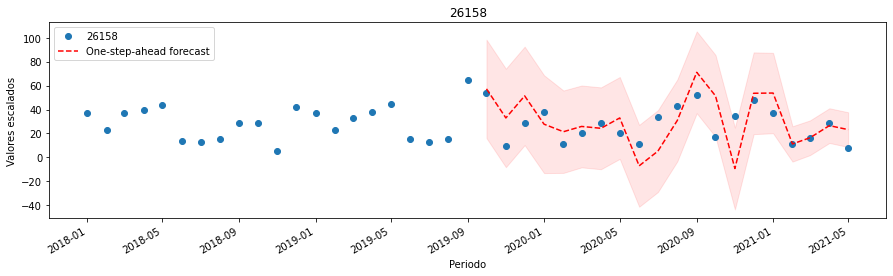

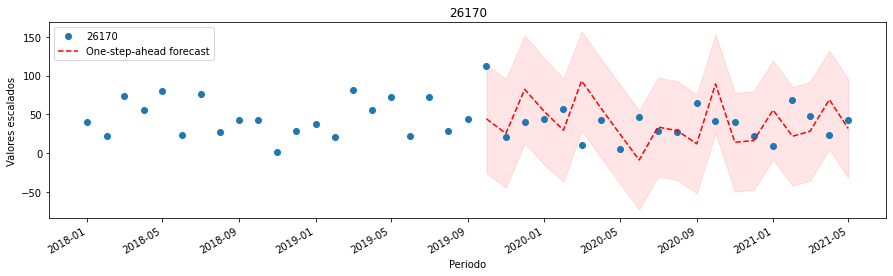

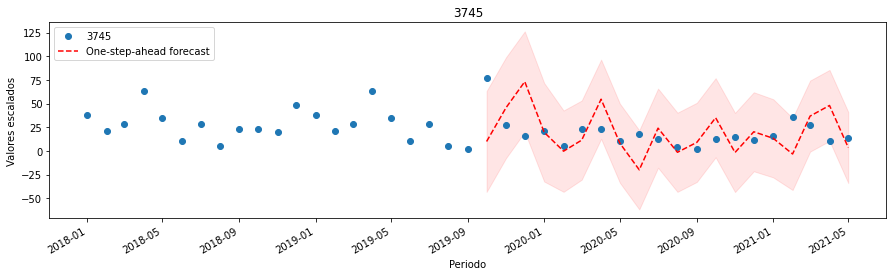

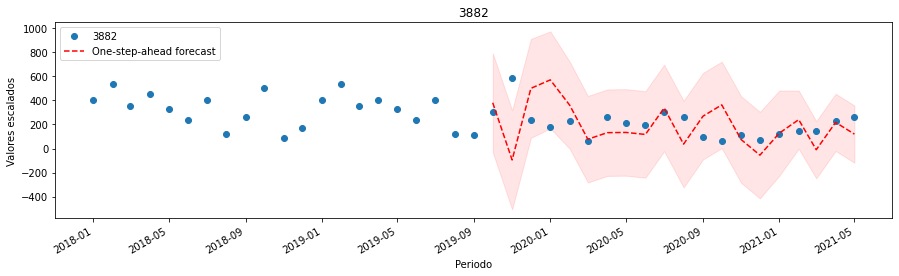

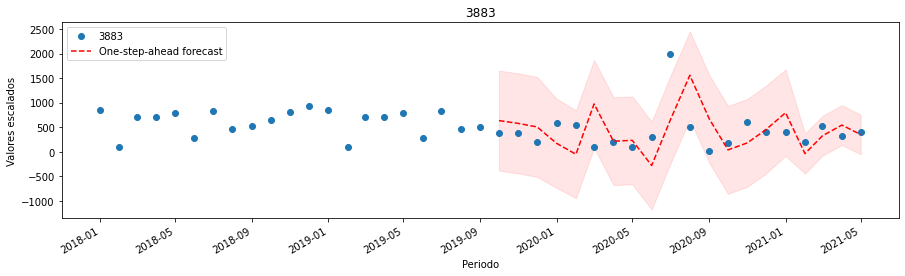

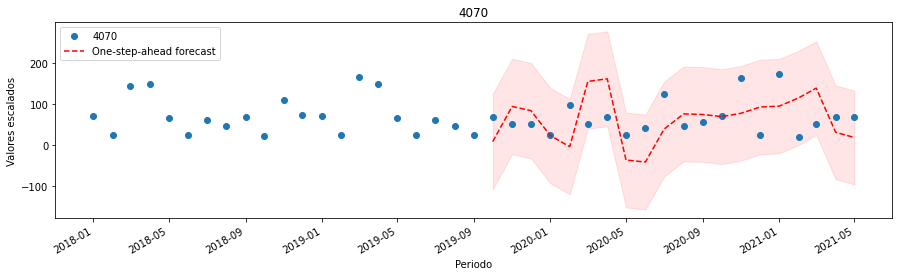

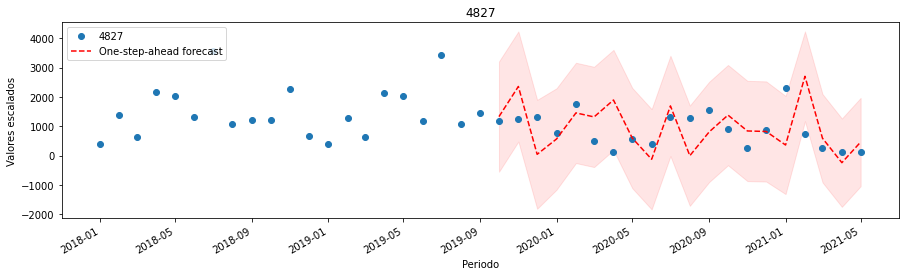

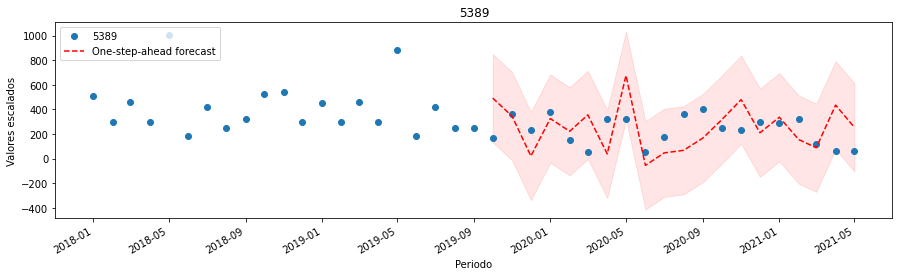

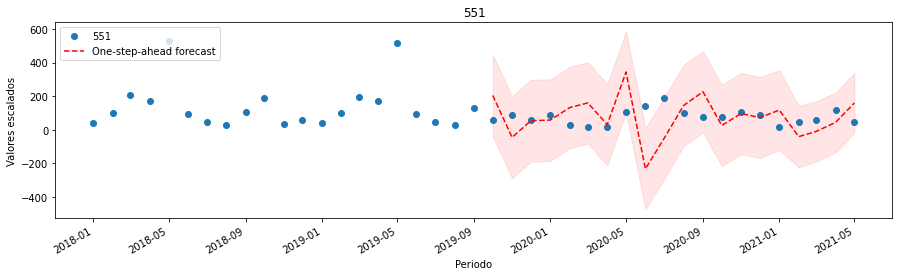

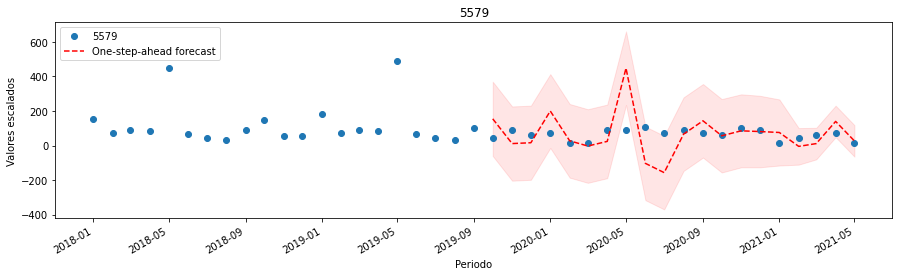

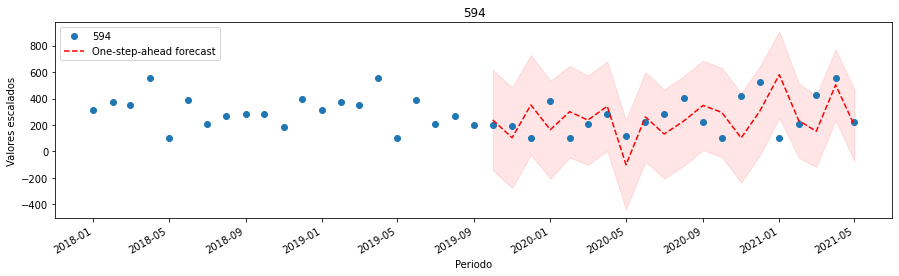

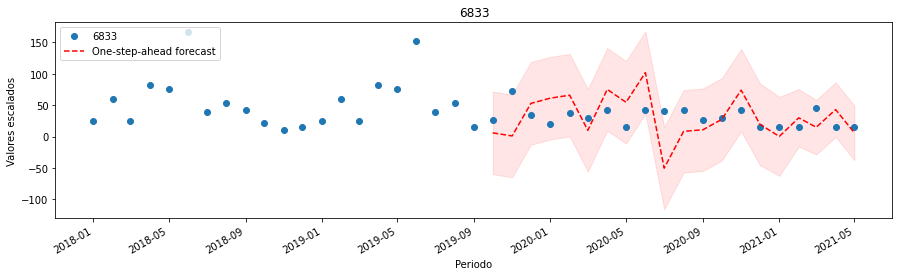

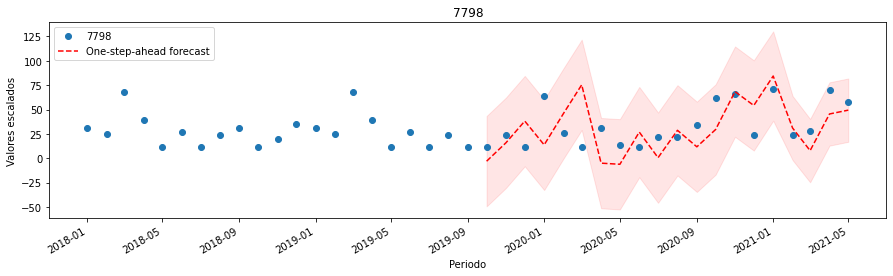

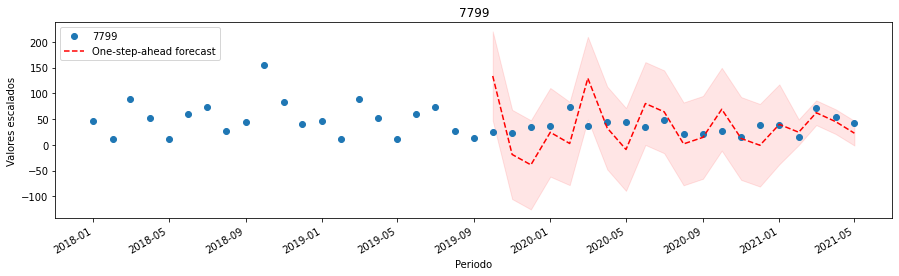

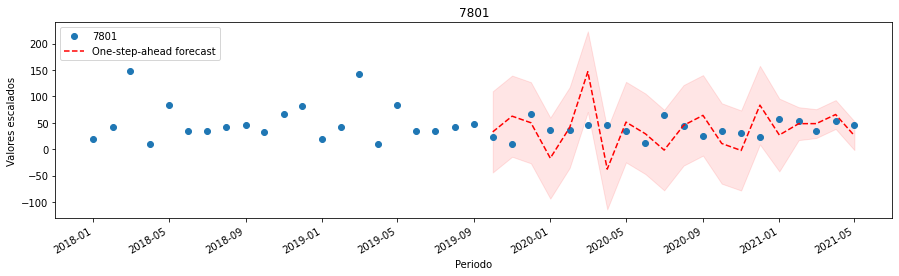

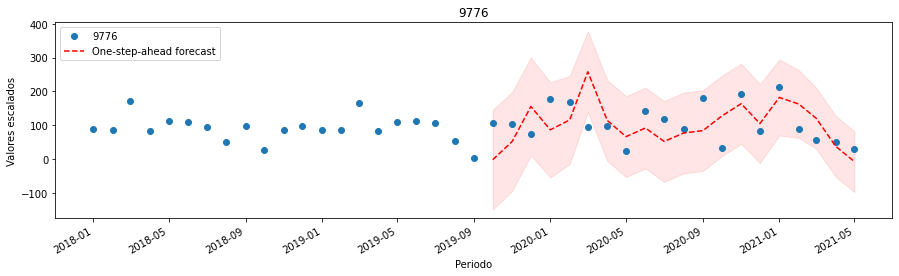

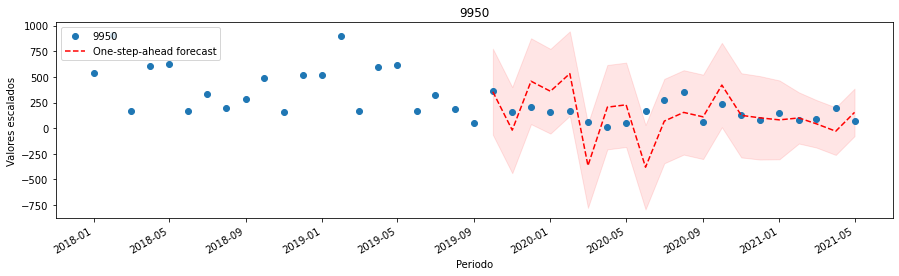

In [77]:
# https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html#
# https://analyzingalpha.com/interpret-arima-results
# https://pandas.pydata.org/pandas-docs/version/0.9.1/timeseries.html#offset-aliases
"""
Prob(Q): debe ser mayor a 0.05 para no rechasar que el error es ruido blanco
Prob(H) (two-sided): debe ser mayor a 0.05 para no rechasar que el error tiene una varianza constante
Jarque-Bera: Prueba que tan normalizada esta la muestra de datos
"""
import statsmodels.api as sm
import datetime
#adfuller_table = pd.DataFrame()
for producto in df_diff.columns.tolist():
    idArticulo = producto# '26170'
    fecha_inicio_pred_print = '2019-10-01'
    mod = sm.tsa.statespace.SARIMAX(df_time[idArticulo], order=(1, 1, 0), seasonal_order=(2, 1, 0, 12),freq='MS')
    res = mod.fit(disp=False)
    print_forecasting_results(df_time[[idArticulo]], res, fecha_inicio_pred_print, title= idArticulo,producto=producto, dynamic=False)
    #print(res.summary())